# Orbital Evolution of Extreme Mass Ratio Inspirals.

Consider an Extreme Mass Ratio Inspiral (EMRI) system. Let the masses of the secondary and the primary be $\mu=2M_\odot$ and $M=10^6\times \mu\ $respectively, where $M_\odot$ is one solar mass. It is approximately equal to $2\times10^{30}\ \mathrm{kg}$.

Since the mass of the secondary is negligible compared to the mass of the primary, its motion in the gravitational field generated by the primary at the zeroth order can be approximated by geodesic motion.

In [1]:
from joblib import Parallel, delayed, cpu_count
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
from os import mkdir
from pandas import DataFrame, read_csv
from scipy.fft import fft, fftfreq
from scipy.integrate import solve_ivp
from sympy import symbols, diff, lambdify, sin, cos, sqrt
from warnings import simplefilter

# disable furure warnings.
simplefilter(action='ignore', category=FutureWarning)

set_matplotlib_formats('svg')
%matplotlib widget

#### Create directory to store data + images.

The creation of this directory is necessary only if we wish to save the plots and data.

In [2]:
try:
    mkdir('./data+images')
    print("Specified directory was created successfully.")
except FileExistsError:
    print("WARNING: Specified directory already exists!")

Specified directory was created successfully.


#### Specify orbital parameters of the system.

In code units, we shall set $M_\odot = 1$. As a result, the masses of the secondary and primary get rescaled to $\mu=2$ and $M=2\times 10^6$ respectively. Additionally, we shall work with geometrized units where $c=G=1$, where $c$ is the speed of light in vacuum and $G$ is the Newtonian gravitational constant.

We shall evolve the orbits of the secondary in a spacetime with a <a href="https://journals.aps.org/prd/abstract/10.1103/PhysRevD.102.064041" style="color:#224C98" target="_blank">modified Johannsen metric</a>. The chosen spacetime is stationary and axisymmetric, and the geodesic equations that describe the motion of the secondary in such spacetimes are derived and explained in `theory.pdf`.

In [3]:
# mass of secondary.
μ = 2.0
# mass of the primary.
M = 1e6*μ
# spin parameter of the primary.
a = 0.99*M
# specific energy of the secondary.
E = 0.95
# specific angular momentum of the secondary about the symmetry axis.
L = 3*M

# deformation parameters in modified Johannsen metric.
αQ = -1.8
α22 = 0.0

#### Define necessary symbols.

The metric components are expressed in Boyer–Lindquist coordinates $(t, r, \theta, \phi)$. Let $(\mathrm{v}r, \mathrm{v}\theta, \mathrm{v}\phi)$ be the rates of change of coordinates $(r, \theta, \phi)$ with respect to the coordinate time $t$. 

In [4]:
t, r, θ, ϕ, vr, vθ, vϕ = symbols('t, r, θ, ϕ, vr, vθ, vϕ')

#### Specify metric components $g_{\mu\nu}.$

In [5]:
# define helper functions.
Σ = r**2 + (a*cos(θ))**2
Δ = r**2 - 2*M*r + a**2
A = 1 + α22*(M/r)**2

# tt-component.
g_tt = -Σ*((αQ/r)*M**3 + Δ - (a*A*sin(θ))**2) / (r**2 + a**2 - A*(a*sin(θ))**2)**2
# tϕ-component.
g_tϕ = -a*((r**2 + a**2)*A - Δ)*Σ*(sin(θ)**2) / (r**2 + a**2 - A*(a*sin(θ))**2)**2
# rr-component.
g_rr = ((αQ/r)*M**3 + Σ)/Δ
# θθ-component.
g_θθ = Σ
# ϕϕ-component.
g_ϕϕ = Σ*(sin(θ)**2)*((r**2 + a**2)**2 - Δ*(a*sin(θ))**2) / (r**2 + a**2 - A*(a*sin(θ))**2)**2

#### Compute partial derivatives of metric components.

All the metric components are functions of $r$ and $\theta$ only. Thus, we just have to calculate the partial derivatives with respect to these 2 coordinates.

In [6]:
# g_αβ_λ represents the partial derivative of g_αβ with respect to the coordinate λ.
g_tt_r = diff(g_tt, r)
g_tt_θ = diff(g_tt, θ)
g_tϕ_r = diff(g_tϕ, r)
g_tϕ_θ = diff(g_tϕ, θ)
g_rr_r = diff(g_rr, r)
g_rr_θ = diff(g_rr, θ)
g_θθ_r = diff(g_θθ, r)
g_θθ_θ = diff(g_θθ, θ)
g_ϕϕ_r = diff(g_ϕϕ, r)
g_ϕϕ_θ = diff(g_ϕϕ, θ)

#### Define effective potential V.

In [7]:
V = (1 + (g_ϕϕ*E**2 + g_tt*L**2 + 2*g_tϕ*E*L)/(g_tt*g_ϕϕ - g_tϕ**2))/g_rr

#### Calculate derivatives of $t$ and $\phi$ with respect to proper time $\tau$.

In [8]:
# dt/dτ.
dt_dτ = (g_ϕϕ*E + g_tϕ*L)/(g_tϕ**2 - g_tt*g_ϕϕ)

# dϕ/dτ.
dϕ_dτ = -(g_tϕ*E + g_tt*L)/(g_tϕ**2 - g_tt*g_ϕϕ)

# second order derivative of t with respect to τ.
d2t_dτ2 = dt_dτ*(vr*diff(dt_dτ, r) + vθ*diff(dt_dτ, θ))

# numeric function dτ/dt.
dτ_dt = njit(lambdify([r, θ], 1/dt_dτ, 'numpy'))

#### Define relevant functions.

In [9]:
# function to calculate vθ from vr.
compute_squared_vθ = njit(lambdify([r, θ, vr], (-(vr**2 + V/dt_dτ**2)*g_rr/g_θθ), 'numpy'))

# function to compute value of the constraint equation expression.
constraint = njit(lambdify([r, θ, vr, vθ], vr**2 + (g_θθ/g_rr)*vθ**2 + V/dt_dτ**2, 'numpy'))

# convert V from symbolic to numeric function.
V = njit(lambdify([r, θ], V, 'numpy'))

#### Curve of vero velocity (CZV).

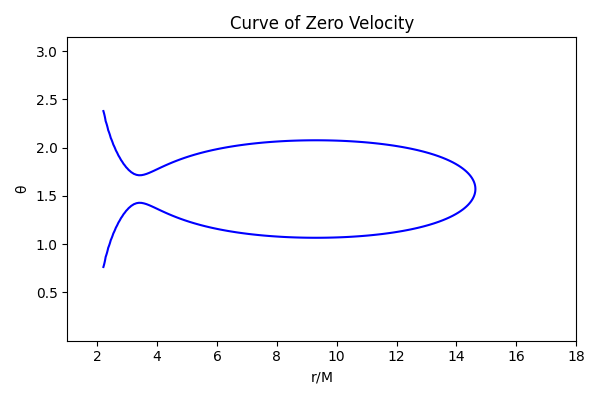

In [10]:
r_array = np.linspace(1*M, 18*M, 200)
θ_array = np.linspace(1e-5, np.pi, 200)

# create grid of r and θ values.
[r_czv, θ_czv] = np.meshgrid(r_array, θ_array)

# mask values that lead to unexpected closing of contour lines.
V_vals = np.ma.masked_where(r_czv/M < 2.15, V(r_czv, θ_czv))

# plot the CZV.
plt.close()
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.contour(r_czv/M, θ_czv, V_vals, levels=[0], colors='blue')
ax.set(title='Curve of Zero Velocity', xlabel=r'$\mathrm{r/M}$', ylabel=r'$\mathrm{\theta}$')
plt.savefig('data+images/czv.pdf', dpi=1600)
plt.show()

#### Specify initial state of system.

In [11]:
@njit
def get_initial_state(r, θ, ϕ, dr_dτ):
    # initial rate of change of r coordinate with respect to t.
    vr = dr_dτ * dτ_dt(r, θ)
    
    # squared change in θ coordinate with respect to t.
    squared_vθ = compute_squared_vθ(r, θ, vr)

    # set very small values to 0. 
    if np.abs(squared_vθ) < 1e-29:
        vθ = 0.0
    else:
        vθ = np.sqrt(squared_vθ)
    
    return np.array([r, θ, ϕ, vr, vθ])

#### Compute ODE functions + acceleration components $(\mathrm{a}r, \mathrm{a}\theta, \mathrm{a}\phi)$.

In [12]:
# derivative of ϕ with respect to t.
dϕ_dt = dϕ_dτ / dt_dτ

# derivative of vr with respect to t.
ar = (-2*g_rr*vr*d2t_dτ2/dt_dτ**2 - g_rr_r*vr**2 + g_tt_r + 2*g_tϕ_r*dϕ_dt
      -2*vr*vθ*g_rr_θ + g_θθ_r*vθ**2 + g_ϕϕ_r*dϕ_dt**2) / (2*g_rr)

# derivative of vθ with respect to t.
aθ = (-2*g_θθ*vθ*d2t_dτ2/dt_dτ**2 + g_rr_θ*vr**2 + g_tt_θ + 2*g_tϕ_θ*dϕ_dt
      -2*vr*vθ*g_θθ_r - g_θθ_θ*vθ**2 + g_ϕϕ_θ*dϕ_dt**2) / (2*g_θθ)

# derivative of vϕ with respect to t.
aϕ = diff(dϕ_dt, r)*vr + diff(dϕ_dt, θ)*vθ

# obtain the numeric versions of the required symbolic functions for solving ODE system.
f_ϕ = njit(lambdify([r, θ], dϕ_dt, 'numpy'))
f_vr = njit(lambdify([r, θ, vr, vθ], ar, 'numpy'))
f_vθ = njit(lambdify([r, θ, vr, vθ], aθ, 'numpy'))

# ODE functions. 
@njit
def ode_funcs(t, sol):
    dr_dt = sol[3]
    dθ_dt = sol[4]
    dϕ_dt = f_ϕ(sol[0], sol[1])
    dvr_dt = f_vr(sol[0], sol[1], sol[3], sol[4])
    dvθ_dt = f_vθ(sol[0], sol[1], sol[3], sol[4])
    return [dr_dt, dθ_dt, dϕ_dt, dvr_dt, dvθ_dt]

#### Calculate geodesics.

In [13]:
# initial state of system.
initial_state = get_initial_state(5.64*M, np.pi/2, 0.0, 0.1)

# approximate orbital period of the secondary around the primary.
P = 1e3*M

# upper time limit of integration.
T = 1e3*P

# timepoints for which we solve the ODE system.
time = np.linspace(0, T, int(3e5))

params = {"fun": ode_funcs, "method": "DOP853", "rtol": 1e-13, "atol": 1e-13}

# solve the system of ODEs.
sol = solve_ivp(t_span=(0, time.max()), y0=initial_state, t_eval=time, **params)

print(sol.message)

The solver successfully reached the end of the integration interval.


In [14]:
# place the calculated quantities in a Pandas DataFrame df.
df = DataFrame({'t': sol.t, 'r': sol.y[0], 'θ': sol.y[1], 'ϕ': sol.y[2],
                'vr': sol.y[3], 'vθ': sol.y[4], 'vϕ': f_ϕ(sol.y[0], sol.y[1])})

df.head()

,t,r,θ,ϕ,vr,vθ,vϕ
0,0.000000e+00,1.128000e+07,1.570796,0.000000,0.069600,1.121654e-08,3.680230e-08
1,6.666689e+06,1.177725e+07,1.642643,0.237302,0.079363,1.025859e-08,3.442373e-08
2,1.333338e+07,1.233520e+07,1.706771,0.459412,0.087785,8.936239e-09,3.223711e-08
3,2.000007e+07,1.294449e+07,1.761415,0.667448,0.094755,7.442199e-09,3.019326e-08
4,2.666676e+07,1.359530e+07,1.805950,0.862214,0.100241,5.923978e-09,2.825071e-08


#### Accuracy check of orbital evolution using constraint equation.

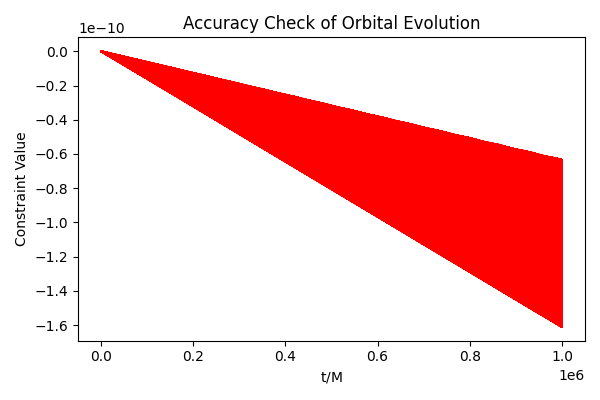

In [15]:
# compute the value of the constraint equation expression to check the accuracy of orbital evolution.
df['constraint'] = constraint(sol.y[0] ,sol.y[1], sol.y[3], sol.y[4])

# plot the values as a function of time t.
plt.close()
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(df['t']/M, df['constraint'], color='red')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 0))
ax.set(title='Accuracy Check of Orbital Evolution', xlabel=r'$\mathrm{t/M}$', ylabel='Constraint Value')
plt.savefig('data+images/accuracy_check.pdf', dpi=1600)
plt.show()

#### 3D motion of secondary in Cartesian coordinates.

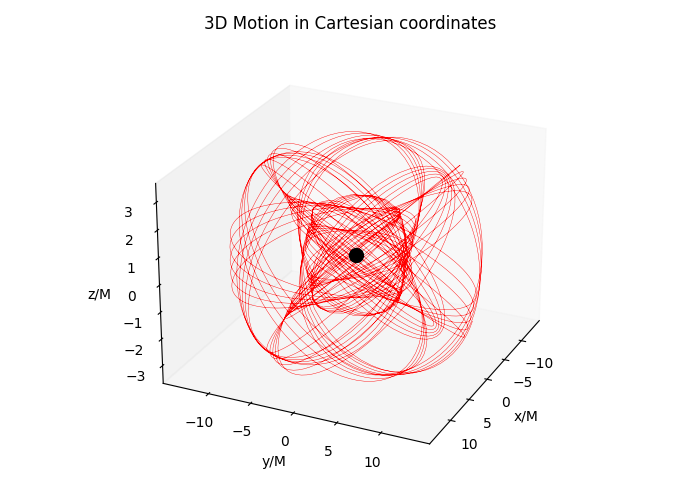

In [16]:
# Coordinate transformation.
x = df['r'] * np.sin(df['θ']) * np.cos(df['ϕ'])
y = df['r'] * np.sin(df['θ']) * np.sin(df['ϕ'])
z = df['r'] * np.cos(df['θ'])

# Plot the orbits with primary at the origin.
plt.close()
fig = plt.figure(figsize=(7, 5), tight_layout=True)
ax = plt.axes(projection ='3d')
ax.scatter3D(0, 0, 0, c='black', s=100, alpha=1.0)
ax.plot((x/M)[:3000], (y/M)[:3000], (z/M)[:3000], color='red', linewidth=0.3)
ax.set(title='3D Motion in Cartesian coordinates', xlabel="x/M", ylabel="y/M", zlabel="z/M")
ax.view_init(25,25)
ax.grid(False)
plt.savefig('data+images/3d-motion.pdf', dpi=1600)
plt.show()

#### Motion of secondary in $(r, \theta)$ plane.

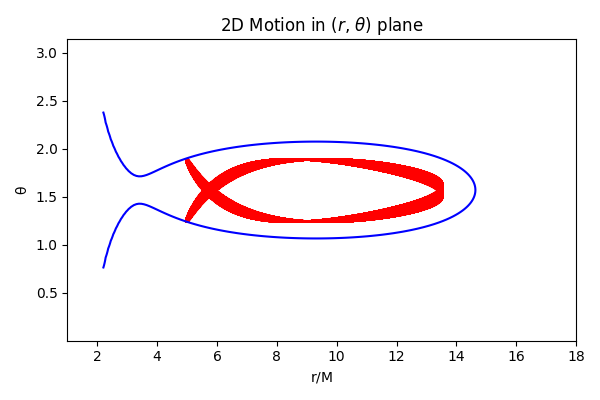

In [17]:
# plot motion in the (r,θ) plane.
plt.close()
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.contour(r_czv/M, θ_czv, V_vals, levels=[0], colors='blue')
ax.set(title=r'2D Motion in $(r$, $\theta)$ plane', xlabel=r'$\mathrm{r/M}$', ylabel=r'$\mathrm{\theta}$')
ax.scatter(df['r']/M, df['θ'], c='red', s=0.01, rasterized=True)
plt.savefig('data+images/2d-motion.pdf', dpi=1600)
plt.show()

#### Gravitational waveform modelling.

In [18]:
# position of secondary in cartesian coordinates.
x = r*sin(θ)*cos(ϕ)
y = r*sin(θ)*sin(ϕ)
z = r*cos(θ)

# velocity components (with respect to t) in cartesian coordinates.
vx = diff(x, r)*vr + diff(x, θ)*vθ + diff(x, ϕ)*vϕ
vy = diff(y, r)*vr + diff(y, θ)*vθ + diff(y, ϕ)*vϕ
vz = diff(z, r)*vr + diff(z, θ)*vθ + diff(z, ϕ)*vϕ

# acceleration components (with respect to t) in cartesian coordinates.
ax = diff(vx, r)*vr + diff(vx, θ)*vθ + diff(vx, ϕ)*vϕ + diff(vx, vr)*ar + diff(vx, vθ)*aθ + diff(vx, vϕ)*aϕ
ay = diff(vy, r)*vr + diff(vy, θ)*vθ + diff(vy, ϕ)*vϕ + diff(vy, vr)*ar + diff(vy, vθ)*aθ + diff(vy, vϕ)*aϕ
az = diff(vz, r)*vr + diff(vz, θ)*vθ + diff(vz, ϕ)*vϕ + diff(vz, vr)*ar + diff(vz, vθ)*aθ + diff(vz, vϕ)*aϕ

Let $\vec{n}$ be a unit 3-vector in the propagation direction of the GWs from the EMRI system to a spaceborne gravitational wave detector like <a href="https://www.cosmos.esa.int/web/lisa" style="color:#224C98" target="_blank">LISA</a>. The polarization plane of an incoming GW is orthogonal to $\vec{n}$. Using a unit 3-vector $\vec{s}$ that points in the direction of the primary’s spin axis (if it exists), we can introduce two orthogonal unit vectors that lie in the plane
of polarization, $$\vec{p} = \frac{\vec{n}\times\vec{s}}{\|\vec{n}\times\vec{s}\|},\hspace{1cm}\vec{q} = \vec{p}\times\vec{n} $$

The set of vectors $\{\vec{n}, \vec{p}, \vec{q}\}$ form a spatial orthonormal basis and the components of the GW polarization tensors can be constructed from them, $$\epsilon_+^{ij}=p^ip^j-q^iq^j,\hspace{1cm}\epsilon_\times^{ij}=p^iq^j-p^jq^i$$

We can express the GW polarizations in terms of the position, velocity and acceleration of the secondary in Cartesian coordinates as:
$$h_{+,×}(t) = \frac{2\mu}{d}\epsilon^{+,\times}_{ij}[a^i(t)x^j(t)-v^i(t)v^j(t)],$$

where $d$ is the luminosity distance from the EMRI system to the detector.

<br>
The $h_+(t)$ waveform shall be calculated with the following values:
<ul>
    <li>$d=8$ kpc$=8\times 10^3\times 3.08567758\times 10^{16}\ m$</li>
    <li>$\vec{n}=\langle 0,0,1\rangle$</li>
    <li>$\vec{s}=\langle 1,0,0\rangle$</li>
</ul>

We can convert the result from code units to geometrized units by multiplying with $1M_\odot$, which is around $1480\ m$. Let us calculate the plus polarization waveform.

In [19]:
# 8 kpc in metres 
d = 8*1e3*3.08567758e16

# factor to convert to geometrized units.
factor = 1480

# expression for the plus polarization state of GWs.
h_plus_expr = factor*(2*μ/d)*(-ax*x - vx*vx + ay*y + vy*vy)

# numeric function to generate the waveform amplitudes.
h_plus = lambdify([r, θ, ϕ, vr, vθ, vϕ], h_plus_expr, 'numpy')

# add the computed amplitudes to df.
df['h_+'] = h_plus(df['r'], df['θ'], df['ϕ'], df['vr'], df['vθ'], df['vϕ'])

# write the dataframe to a csv file.
df.to_csv('data+images/orbital_evolution+gw_data.csv', index=False)

df.head()

,t,r,θ,ϕ,vr,vθ,vϕ,constraint,h_+
0,0.000000e+00,1.128000e+07,1.570796,0.000000,0.069600,1.121654e-08,3.680230e-08,0.000000e+00,8.112321e-18
1,6.666689e+06,1.177725e+07,1.642643,0.237302,0.079363,1.025859e-08,3.442373e-08,1.342329e-14,7.563315e-18
2,1.333338e+07,1.233520e+07,1.706771,0.459412,0.087785,8.936239e-09,3.223711e-08,-5.075801e-15,5.649410e-18
3,2.000007e+07,1.294449e+07,1.761415,0.667448,0.094755,7.442199e-09,3.019326e-08,2.536166e-15,3.137140e-18
4,2.666676e+07,1.359530e+07,1.805950,0.862214,0.100241,5.923978e-09,2.825071e-08,1.989728e-15,6.366207e-19


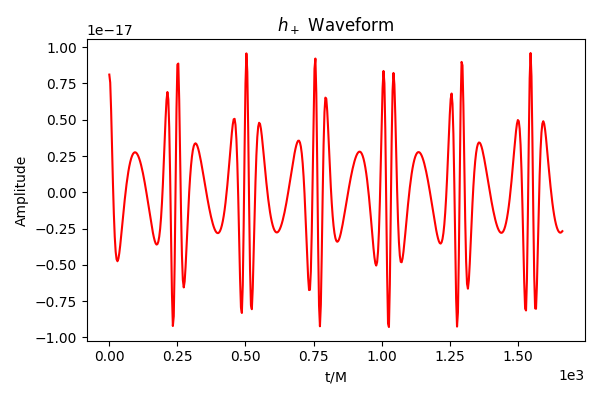

In [20]:
# plot the waveform.
plt.close()
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot((df['t']/M)[:500], df['h_+'][:500], color='red')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 0))
ax.set(title='$h_+$ Waveform', xlabel=r'$\mathrm{t/M}$', ylabel='Amplitude')
plt.savefig('data+images/h+_waveform.pdf', bbox_inches='tight', dpi=1600)
plt.show()

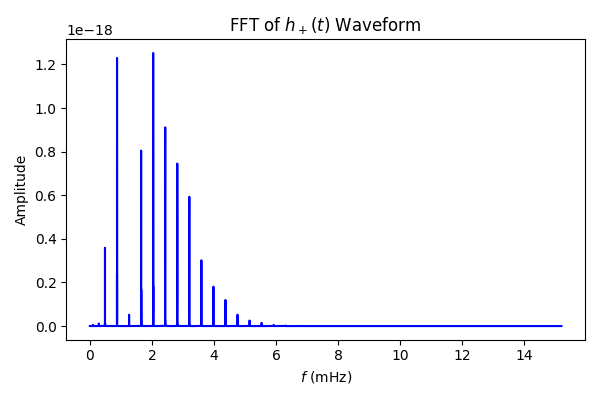

In [21]:
dt = df['t'].iloc[1] - df['t'].iloc[0] 
N = df['t'].size
yf = np.abs(fft(df['h_+'].values))/N
freq = fftfreq(N, dt)

# plot the result of FFT on the waveform.
plt.close()
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
# we get the frequencies in Hz by multiplying with (speed of light)/factor.
# additional multiplication by 1e3 gives the frequency in mHz.
ax.plot(freq[0:N//2]*1e3*(3e8/factor), yf[0:N//2], color='blue')
ax.set(title='FFT of $h_+(t)$ Waveform', xlabel=r'$f\ (\mathrm{mHz})$', ylabel='Amplitude')
plt.savefig('data+images/h+_FFT.pdf', dpi=1600)
plt.show()

A zoomed-in view of the Fourier peaks are shown below:

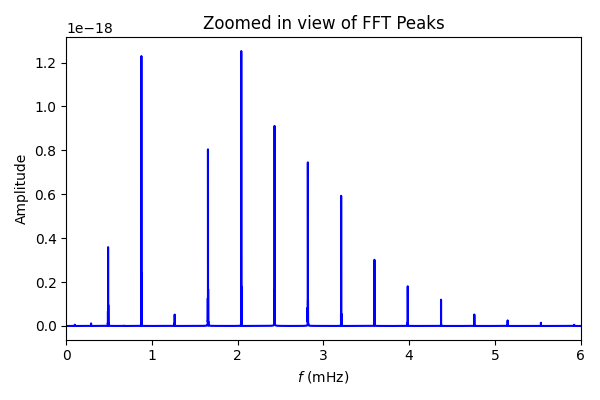

In [22]:
plt.close()
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(freq[0:N//2]*1e3*(3e8/factor), yf[0:N//2], color='blue')
ax.set(title='Zoomed in view of FFT Peaks', xlabel=r'$f\ (\mathrm{mHz})$', ylabel='Amplitude', xlim=(0, 6))
plt.savefig('data+images/h+_FFT_zoomed_in.pdf', dpi=1600)
plt.show()

#### Testing Liouville integrability.

Poincaré surface of section and Rotation number curves can be used to test the integrability of the equations of motion. In the case of non-integrability, Birkhoff chains of islands can be seen in the Poincaré map and a plateau region is visible in the Rotation number curve. We shall first determine the stable fixed point $u_0$ around which most closed curves lie.

##### Fixed point $u_0$.

The fixed point corresponds to circular orbits that always cross the equatorial plane at the same point. To determine $u_0$, the orbits are evolved by varying the initial value of the r coordinate, till we get the plot of the orbit in the $(r, \theta)$ plane as a straight line. This line is perpendicular to the r-axis since the value of r does not change for circular orbits.

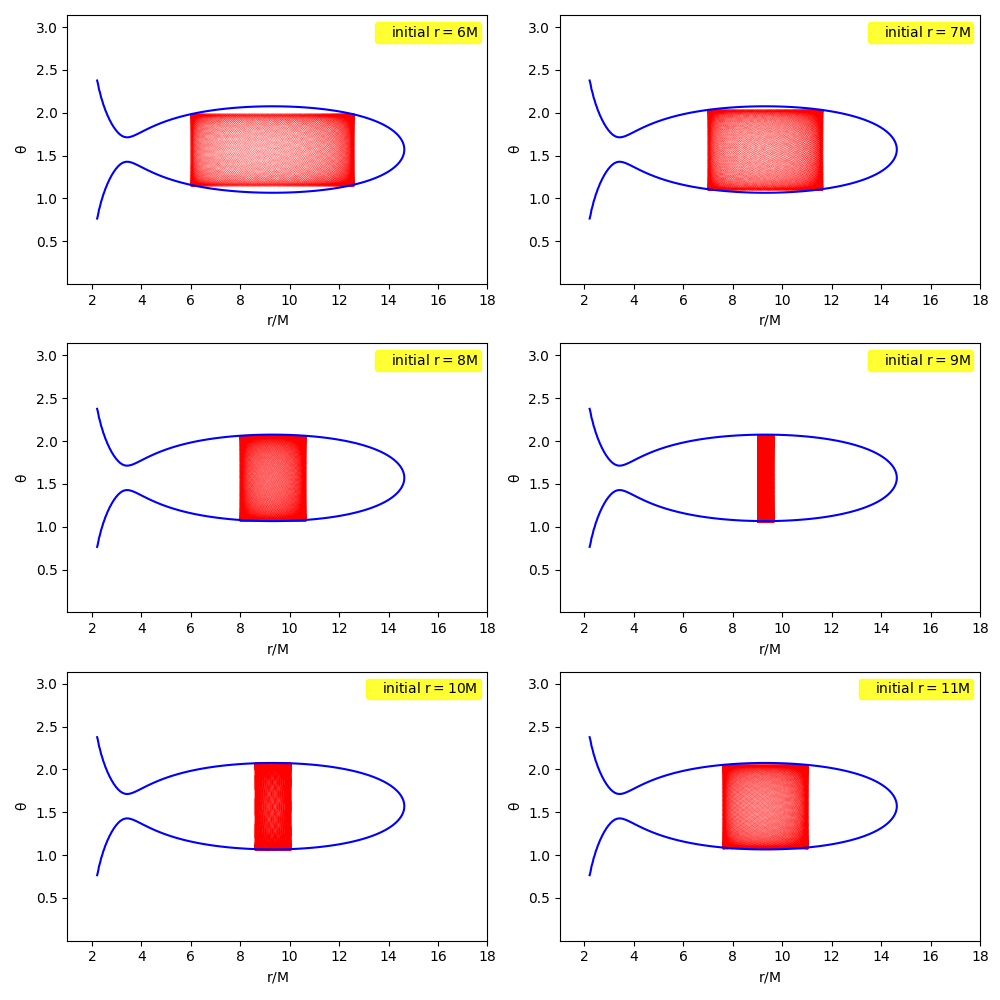

In [23]:
# integration time to determine the fixed point. 
time = np.linspace(0, 4e2*P, int(5e4))

# create orbital plots in the (r,θ) plane for different initial values of r.
def generate_subplots(r_values):
    
    plt.close()
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), tight_layout=True)
    
    # index for rows.
    row = 0
    
    for idx, val in enumerate(r_values):
        
        initial_state = get_initial_state(val*M, np.pi/2, 0.0, 0.0)
        
        sol = solve_ivp(t_span=(0, time.max()), y0=initial_state, t_eval=time, **params)
        
        # column index value is 0 for even row index and 1 for odd row index.
        col = idx & 1
        
        # subplot label.
        label = r'initial $\mathrm{r}=$' + str(val) + r'$\mathrm{M}$'
        
        ax[row, col].contour(r_czv/M, θ_czv, V_vals, levels=[0], colors='blue')
        ax[row, col].scatter(sol.y[0]/M, sol.y[1], c='red', s=0.001, rasterized=True, label=label)
        ax[row, col].set(xlabel=r'$\mathrm{r/M}$', ylabel=r'$\mathrm{\theta}$')
        ax[row, col].legend(borderpad=0.2, handlelength=0.15, facecolor='yellow', edgecolor='yellow')
    
        # update row index if column index is odd.
        if col:
            row += 1
            
    plt.show()

# initial r/M values to evolve the orbits. 
test_vals = range(6, 12)

generate_subplots(test_vals)

The fixed point seems to be close to $r=9M$. Let us refine our search:

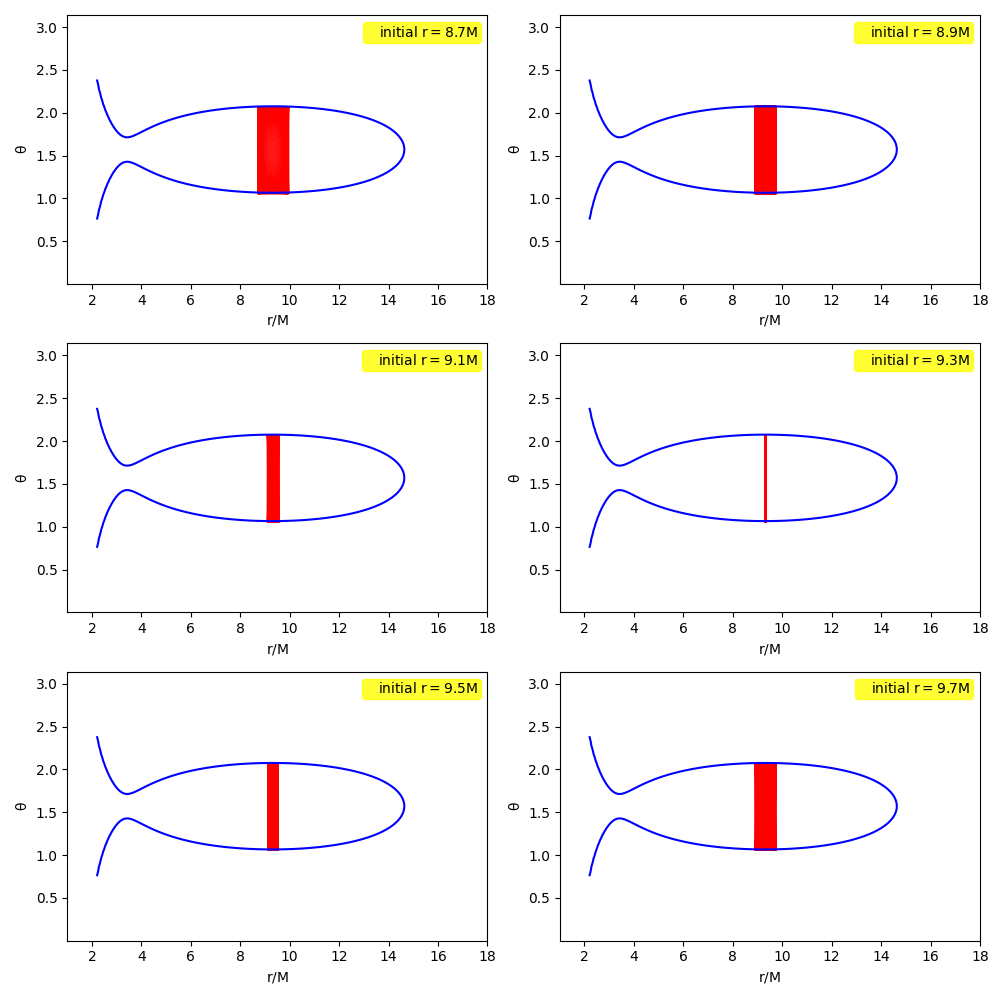

In [24]:
# refined values to evolve the orbits. 
refined_test_vals = np.round(np.arange(8.7, 9.8, 0.2), 2)

generate_subplots(refined_test_vals)

From the subplots above, we see that the fixed point $u_0\approx9.3M$

The fixed point will be a different one when we introduce changes in the metric parameters or when we use different values for $E$ and $L$. 

Let us now define some essential functions:

In [25]:
# function defines the event of crossing the equatorial plane.
@njit
def events(t, sol):
    return sol[1] - np.pi/2

# function to calculate the angle between 2 vectors.
@njit
def calculate_angle(v1, v2):
    angle1 = np.arctan2(v1[:, 1], v1[:, 0])
    angle2 = np.arctan2(v2[:, 1], v2[:, 0])
    return np.mod(angle2 - angle1, 2*np.pi)

# function to compute rotation number. 
@njit
def compute_rotation_number(arr):
    return arr.sum() / (2*np.pi*arr.size)

In [26]:
fixed_point = np.array([9.3*M, 0])

# array of initial r values for position of the secondary. 
r_values = np.concatenate([np.linspace(3.5*M, 3.685*M, 7), np.linspace(3.69*M, 3.72*M, 10),
                           np.linspace(3.725*M, 4.94*M, 18), np.linspace(4.945*M, 4.97*M, 4),
                           np.linspace(4.975*M, 5.58*M, 8), np.linspace(5.585*M, 5.69*M, 3),
                           np.linspace(6*M, 8.9*M, 4), np.array([9.3*M])])

print(f"Number of items in r_values array: {r_values.size}")

Number of items in r_values array: 55


In [27]:
# integration time to compute Poincare map + Rotation number curve. 
time = np.linspace(0, 5e2*P, int(1e5))

# function to generate values for Poincare map + Rotation curve.
def integrability_test(r): 
    # define initial_state
    initial_state = get_initial_state(r, np.pi/2, 0.0, 0.0)

    # solve the ODE system for the given initial state.
    sol = solve_ivp(t_span=(0, time.max()), y0=initial_state, t_eval=time, events=events, **params)
    
    # values that satisfy the event condition.
    y = sol.y_events[0]

    # create a mask to only consider orbits that pierce the equatorial plane in a specific direction. 
    mask = (y[:, 4] > 0)

    # 2D array of r and vr values.
    poincare_array = np.stack((y[mask][:, 0], y[mask][:, 3]), axis=1)

    with open("data+images/poincare_map_data.txt", 'a') as f:
        np.savetxt(f, poincare_array, delimiter=',')
    
    # calculate the angles between the vectors.
    angles = calculate_angle(poincare_array[1:] - fixed_point, poincare_array[:-1] - fixed_point)

    # compute the rotation number.
    rotation_num = compute_rotation_number(angles)

    rot_num_array = np.array([[r, rotation_num]])
    
    with open("data+images/rotation_num_data.txt", 'a') as f:
        np.savetxt(f, rot_num_array, delimiter=',')

In [28]:
n = cpu_count()
print(f"Number of available CPUs: {n}")

Number of available CPUs: 8


In [29]:
Parallel(n_jobs=n, verbose=10)(delayed(integrability_test)(r) for r in r_values);

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  3.5min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  5.9min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  7.2min
[Parallel(n_jobs=8)]: Done  46 out of  55 | elapsed:  8.4min remaining:  1.6min
[Parallel(n_jobs=8)]: Done  52 out of  55 | elapsed:  9.4min remaining:   32.5s
[Parallel(n_jobs=8)]: Done  55 out of  55 | elapsed:  9.4min finished


#### Poincaré surface of section.

In [30]:
poincare_df = read_csv("data+images/poincare_map_data.txt", names=['r', 'vr'])
poincare_df.head()

,r,vr
0,7.246667e+06,0.000000
1,2.747686e+07,0.048405
2,7.315855e+06,-0.010926
3,2.042782e+07,0.118060
4,7.546147e+06,-0.024938


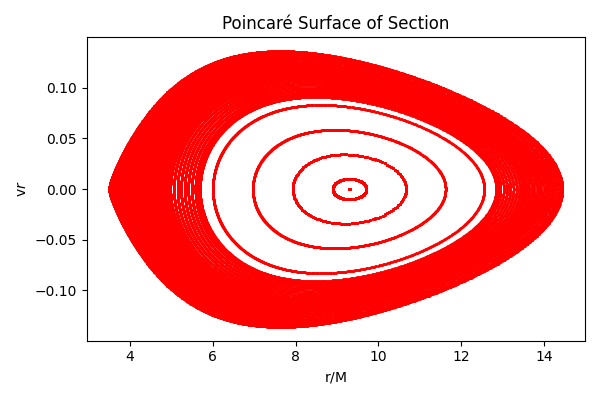

In [31]:
# plot Poincaré map
plt.close()
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.scatter(poincare_df['r']/M, poincare_df['vr'], c='red', s=0.3)
ax.set(title='Poincaré Surface of Section', xlabel=r'$\mathrm{r/M}$', ylabel=r'$\mathrm{v}r$')
plt.savefig('data+images/poincaré_map.pdf', dpi=1600)
plt.show()

The Birkhoff chains of islands associated with stable periodic orbits of 1/2− resonance are shown below:

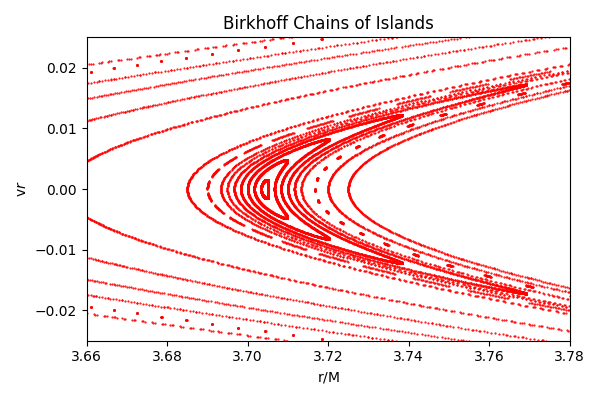

In [32]:
# plot Birkhoff islands.
plt.close()
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.scatter(poincare_df['r']/M, poincare_df['vr'], c='red', s=0.3)
ax.set(title='Birkhoff Chains of Islands', xlabel=r'$\mathrm{r/M}$',
       ylabel=r'$\mathrm{v}r$', xlim=(3.66, 3.78), ylim=(-0.025, 0.025))
plt.savefig('data+images/birkhoff_islands.pdf', dpi=1600)
plt.show()

#### Rotation number curve.

In [33]:
rotation_num_df = read_csv("data+images/rotation_num_data.txt", names=['r', 'rotation_num'])
# values are unordered due to running the calculations in parallel.
rotation_num_df.sort_values(by=['r'], inplace=True)
rotation_num_df.head()

,r,rotation_num
7,7.000000e+06,0.403880
1,7.061667e+06,0.424507
4,7.123333e+06,0.442399
6,7.185000e+06,0.457807
0,7.246667e+06,0.471120


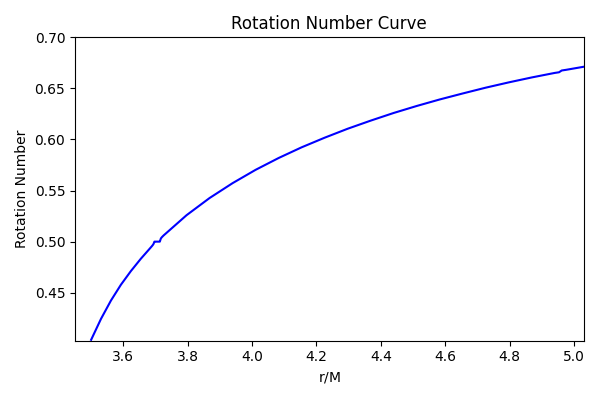

In [34]:
plt.close()
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(rotation_num_df['r']/M, rotation_num_df['rotation_num'], color='blue')
ax.set(title='Rotation Number Curve', xlabel=r'$\mathrm{r/M}$',
       ylabel=r'Rotation Number', xlim=(3.45, 5.03), ylim=(0.403, 0.70))
plt.savefig('data+images/rotation_num_curve.pdf', dpi=1600)
plt.show()

A zoomed-in view of the plateau associated with stable periodic orbits of 1/2− resonance is shown below:

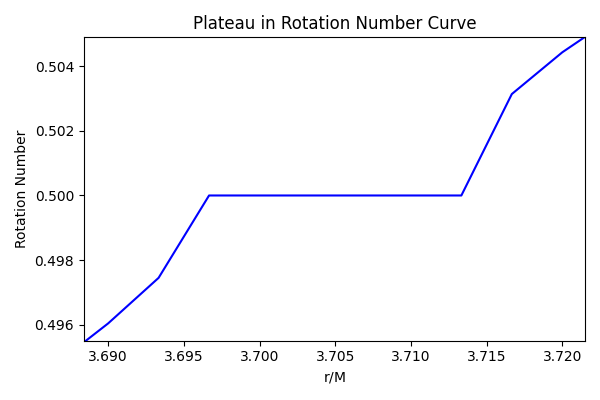

In [35]:
plt.close()
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(rotation_num_df['r']/M, rotation_num_df['rotation_num'], color='blue')
ax.set(title='Plateau in Rotation Number Curve', xlabel=r'$\mathrm{r/M}$',
       ylabel=r'Rotation Number', xlim=(3.6884, 3.7215), ylim=(0.4955, 0.5049))
plt.savefig('data+images/plateau_rotation_num_curve.pdf', dpi=1600)
plt.show()

Therefore, geodesic equations are non-integrable in the modified Johannsen spacetime for the chosen values of the deformation parameter. If they are made to vanish, the spacetime becomes Kerr and the equations of motion become integrable.